In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json

In [2]:
from matplotlib.pylab import rcParams
%matplotlib inline

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [59]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import pprint

In [5]:
TEST_DATA_PATH = '../data/origin/test/'
TRAIN_DATA_PATH = '../data/origin/train/'

# instead of weather_station_to_county_mapping.csv, use fabiendaniels-mapping-locations-and-county-codes
# https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
county_mapper = '../data/origin/county_lon_lats.csv'

test_csv = f'{TEST_DATA_PATH}test.csv'
test_client_csv = f'{TEST_DATA_PATH}client.csv'
test_electricity_prices_csv = f'{TEST_DATA_PATH}electricity_prices.csv'
test_forecast_weather_csv = f'{TEST_DATA_PATH}forecast_weather.csv'
test_gas_prices_csv = f'{TEST_DATA_PATH}gas_prices.csv'
test_historical_weather_csv = f'{TEST_DATA_PATH}historical_weather.csv'
# test_weather_station_to_county_mapping_csv = f'{TEST_DATA_PATH}weather_station_to_county_mapping.csv'
# test_county_id_to_name_map_json = f'{TEST_DATA_PATH}county_id_to_name_map.json'

train_csv = f'{TRAIN_DATA_PATH}train.csv'
train_client_csv = f'{TRAIN_DATA_PATH}client.csv'
train_electricity_prices_csv = f'{TRAIN_DATA_PATH}electricity_prices.csv'
train_forecast_weather_csv = f'{TRAIN_DATA_PATH}forecast_weather.csv'
train_gas_prices_csv = f'{TRAIN_DATA_PATH}gas_prices.csv'
train_historical_weather_csv = f'{TRAIN_DATA_PATH}historical_weather.csv'
# train_weather_station_to_county_mapping_csv = f'{TRAIN_DATA_PATH}weather_station_to_county_mapping.csv'
# train_county_id_to_name_map_json = f'{TRAIN_DATA_PATH}county_id_to_name_map.json'

In [6]:
df_train = pd.read_csv(train_csv)
df_train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [ ]:
df_train.info()

In [ ]:
df_train.shape

In [ ]:
# 결측치 확인 부분
df_train.isna().sum()

In [ ]:
df_train[df_train['target'].isna()]

In [ ]:
df_train[df_train['target'].isna()]['county'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['is_business'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['product_type'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['is_consumption'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['datetime'].value_counts()

In [7]:
# 일단은 결측치 제거하고 시작
# df_train.dropna(inplace=True)
df_train['target'].fillna(df_train['target'].shift(1).fillna(df_train['target'].shift(-1).mean()))

0            0.713
1           96.590
2            0.000
3           17.314
4            2.904
            ...   
2018347    197.233
2018348      0.000
2018349     28.404
2018350      0.000
2018351    196.240
Name: target, Length: 2018352, dtype: float64

In [9]:
df_train[df_train['target'].isna()].value_counts()

Series([], Name: count, dtype: int64)

In [10]:
# 통계적 상황 구경
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
county,2018352.0,7.297034e+00,4.780990,0.0,3.000,7.000,1.100000e+01,15.000
is_business,2018352.0,5.368261e-01,0.498642,0.0,0.000,1.000,1.000000e+00,1.000
product_type,2018352.0,1.898927e+00,1.081766,0.0,1.000,2.000,3.000000e+00,3.000
target,2017824.0,2.748556e+02,909.502378,0.0,0.378,31.133,1.802062e+02,15480.274
is_consumption,2018352.0,5.000000e-01,0.500000,0.0,0.000,0.500,1.000000e+00,1.000
data_block_id,2018352.0,3.218746e+02,182.634314,0.0,166.000,323.000,4.790000e+02,637.000
row_id,2018352.0,1.009176e+06,582648.179598,0.0,504587.750,1009175.500,1.513763e+06,2018351.000
prediction_unit_id,2018352.0,3.304538e+01,19.590594,0.0,16.000,33.000,5.000000e+01,68.000


In [11]:
# TODO: date unique값 처리 - 빠뜨린 시간있는지 확인용?
df_train[(df_train['datetime'] >= '2021-09-01 00:00:00') &
         (df_train['datetime'] <= '2021-09-01 23:00:00')]['datetime'].unique()

array(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
       '2021-09-01 02:00:00', '2021-09-01 03:00:00',
       '2021-09-01 04:00:00', '2021-09-01 05:00:00',
       '2021-09-01 06:00:00', '2021-09-01 07:00:00',
       '2021-09-01 08:00:00', '2021-09-01 09:00:00',
       '2021-09-01 10:00:00', '2021-09-01 11:00:00',
       '2021-09-01 12:00:00', '2021-09-01 13:00:00',
       '2021-09-01 14:00:00', '2021-09-01 15:00:00',
       '2021-09-01 16:00:00', '2021-09-01 17:00:00',
       '2021-09-01 18:00:00', '2021-09-01 19:00:00',
       '2021-09-01 20:00:00', '2021-09-01 21:00:00',
       '2021-09-01 22:00:00', '2021-09-01 23:00:00'], dtype=object)

In [12]:
# TODO: data pandas그거로 바꿈
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

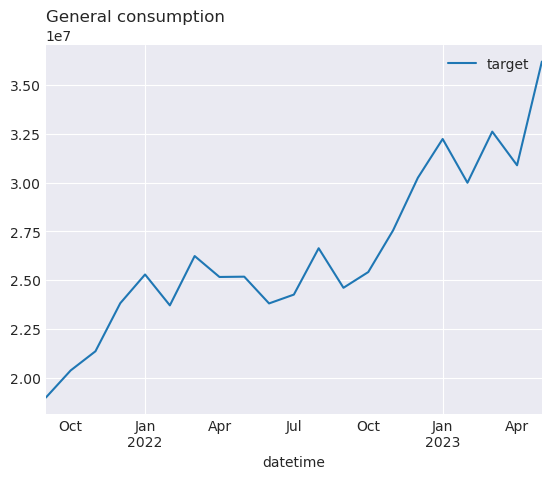

In [13]:
# TODO: datetime set index해서 group by하기
df_train.set_index('datetime').groupby(pd.Grouper(freq='MS'))[['target']].sum().plot()
plt.title('General consumption', loc='left')
plt.show()

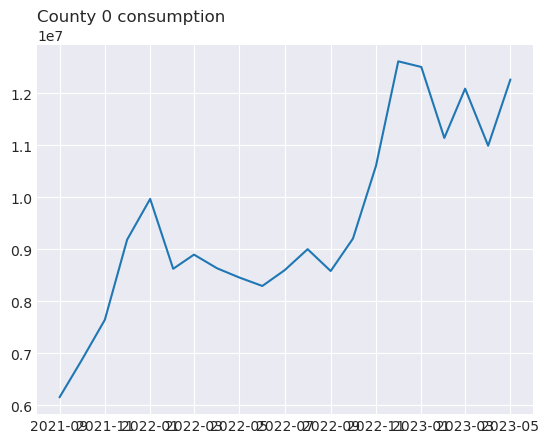

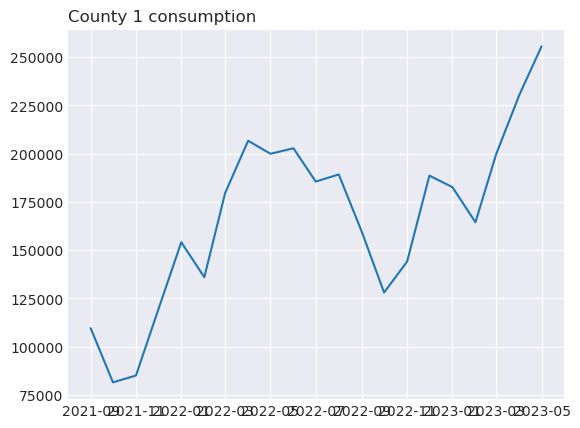

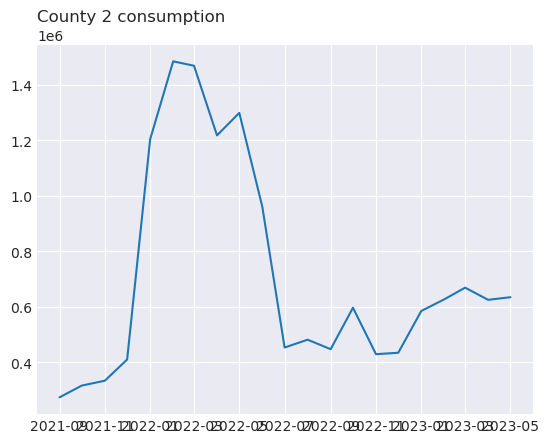

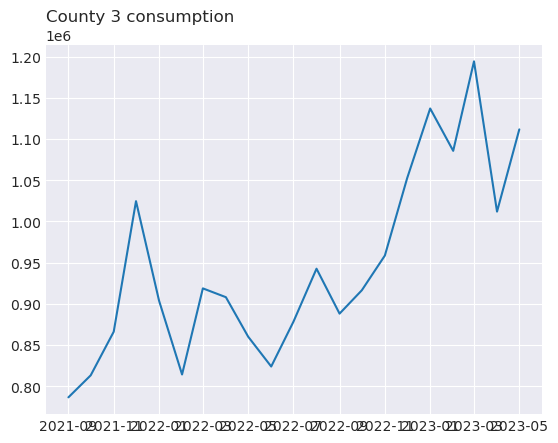

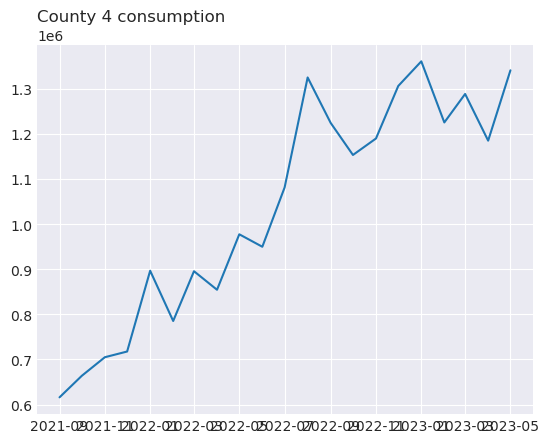

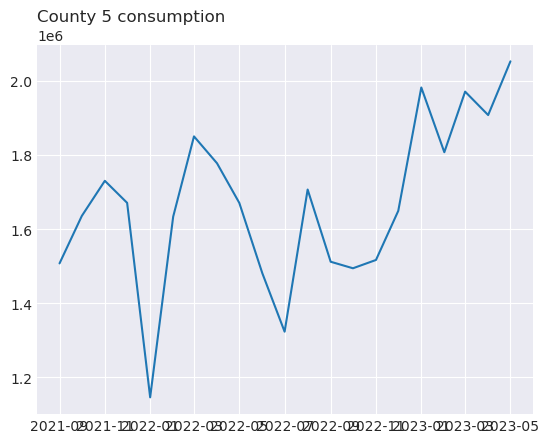

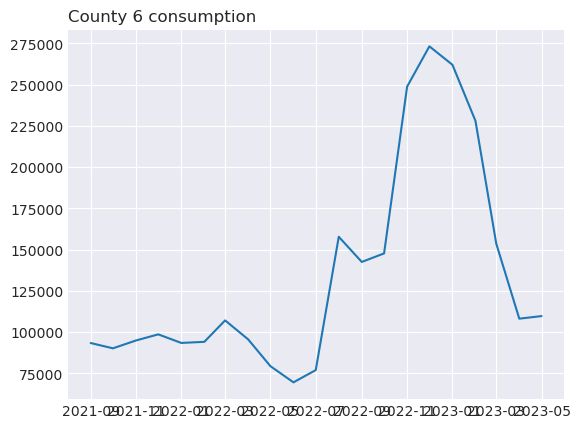

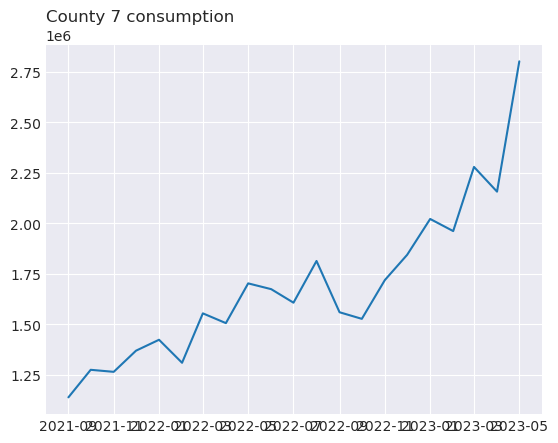

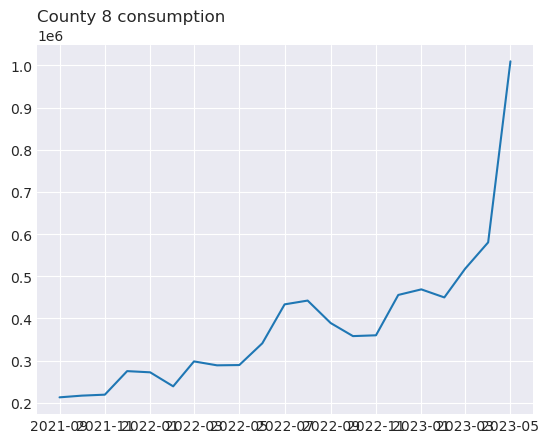

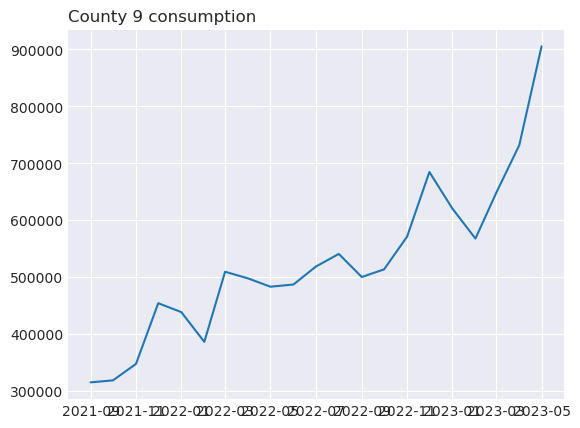

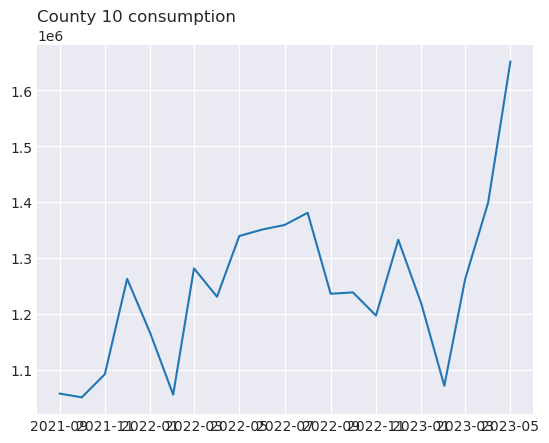

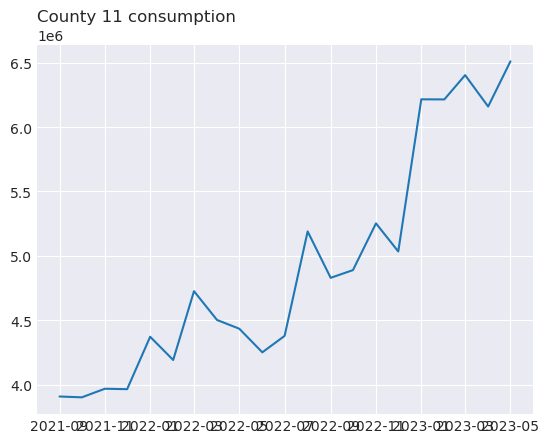

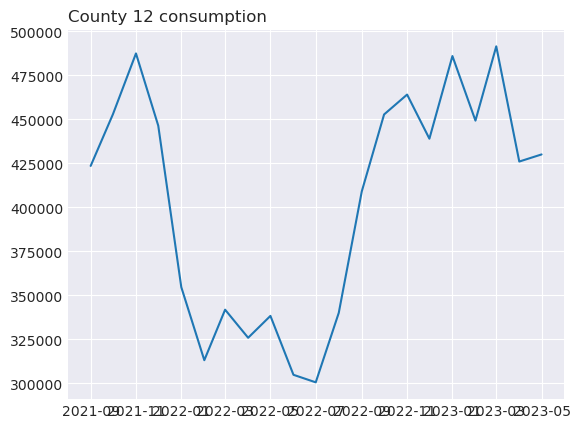

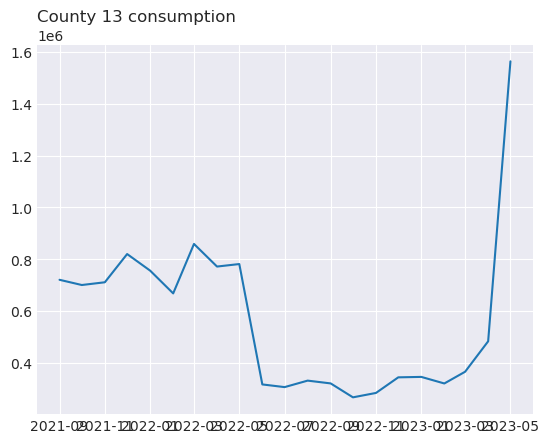

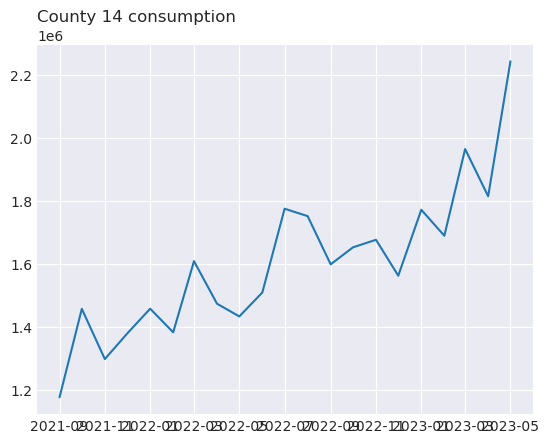

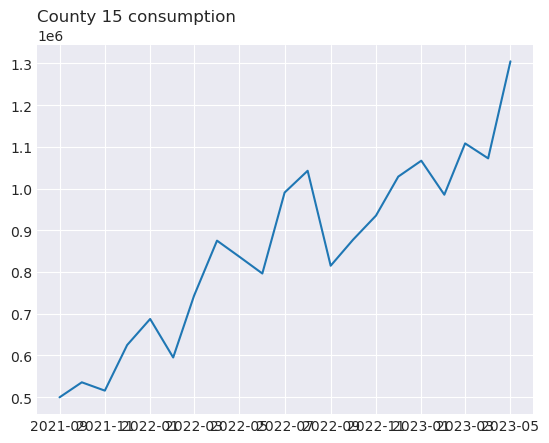

In [14]:
# County 별 consumption plot
for county in df_train['county'].unique():
    plt.title(f'County {county} consumption', fontsize=12, loc='left')
    df_fill_group = df_train.query('county == @county').set_index('datetime')[['target']].groupby(pd.Grouper(freq='MS')).sum().copy()
    plt.plot(df_fill_group.index, df_fill_group['target'])
    plt.show()

In [15]:
# 각 parameter별로 그룹 화 하기
df_month = df_train.set_index('datetime').groupby(['is_business', 'product_type', 'is_consumption', 'county',
                                                  pd.Grouper(freq='MS')])[['target']].sum().reset_index().copy()

In [16]:
df_month.columns

Index(['is_business', 'product_type', 'is_consumption', 'county', 'datetime',
       'target'],
      dtype='object')

In [17]:
# TODO: Stationary
for consumption in df_month['is_consumption'].unique():
    print(f'Is consumption: {consumption}')
    df_fill = df_month.groupby(['is_consumption', 'datetime'], as_index=False)[['target']].sum().copy()
    check = adfuller(df_fill.query('is_consumption == @consumption').set_index('datetime')[['target']])
    pprint.pprint(check)
    if check[1] <= 0.05:
        print("Reject the null hypothesis - the time series is likely stationary.")
    else:
        print("Fail to reject the null hypothesis - the time series may have a unit root and is likely non-stationary.")
    print('')

Is consumption: 0
(1.1075272481770164,
 0.9952803553217605,
 8,
 12,
 {'1%': -4.137829282407408,
  '10%': -2.7144769444444443,
  '5%': -3.1549724074074077},
 366.9931168300063)
Fail to reject the null hypothesis - the time series may have a unit root and is likely non-stationary.

Is consumption: 1
(-1.630846999402135,
 0.4670473909725571,
 6,
 14,
 {'1%': -4.01203360058309,
  '10%': -2.6909873469387753,
  '5%': -3.1041838775510207},
 380.2895443284565)
Fail to reject the null hypothesis - the time series may have a unit root and is likely non-stationary.



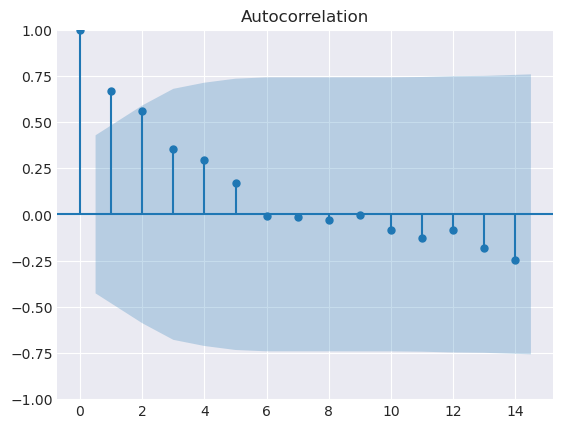

In [18]:
# TODO: Autocorrelation
plot_acf(df_month.groupby('datetime')[['target']].sum())
plt.show()

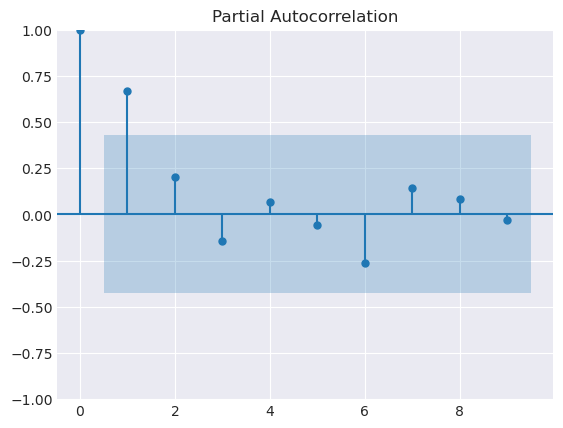

In [19]:
#TODO: Partial Autocorrelation
plot_pacf(df_month.groupby('datetime')[['target']].sum(), lags=9)
plt.show()

In [65]:
df_train.dropna(inplace=True)

In [66]:
# TODO: ARIMA 모델 적용준비

df_arima = df_train[(df_train['is_consumption'] == 0) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()



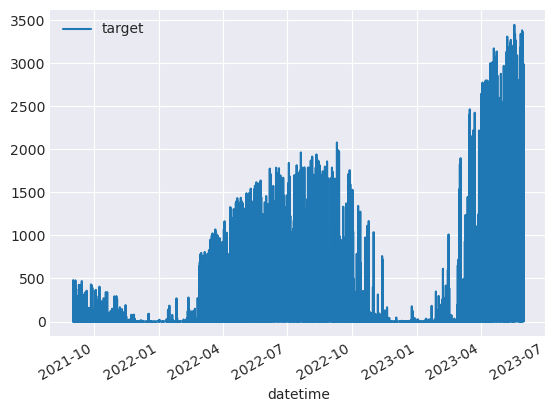

In [67]:
df_arima.plot()
plt.show()

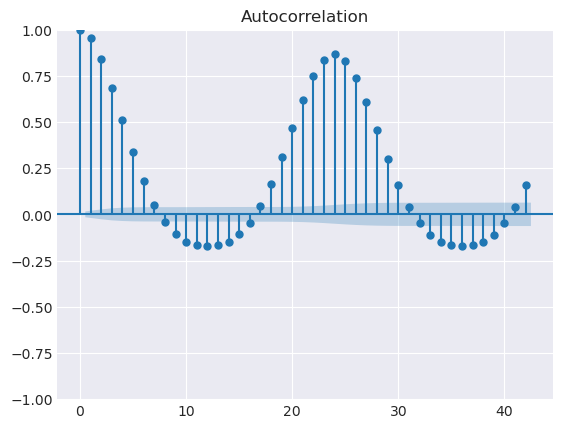

In [68]:
plot_acf(df_arima)
plt.show()

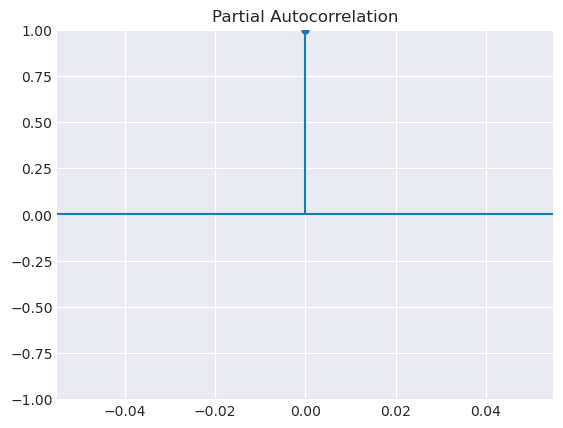

In [29]:
plot_pacf(df_arima)
plt.show()

In [69]:
df_arima_nc = df_train[(df_train['is_consumption'] == 1) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()


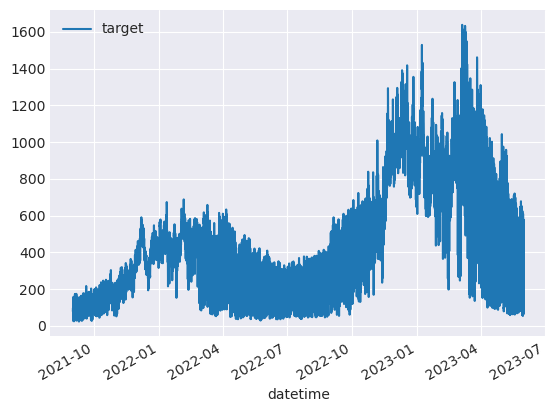

In [70]:
df_arima_nc.plot()
plt.show()

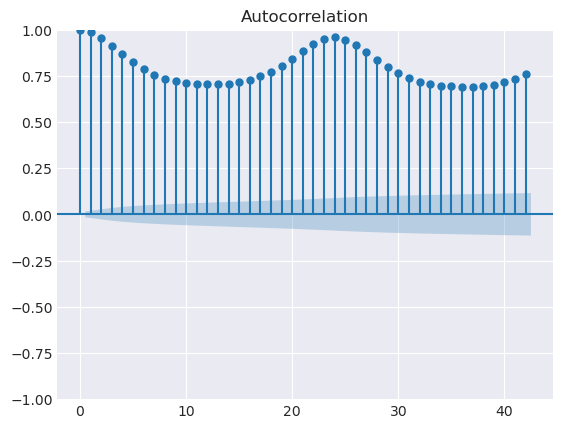

In [71]:
plot_acf(df_arima_nc)
plt.show()

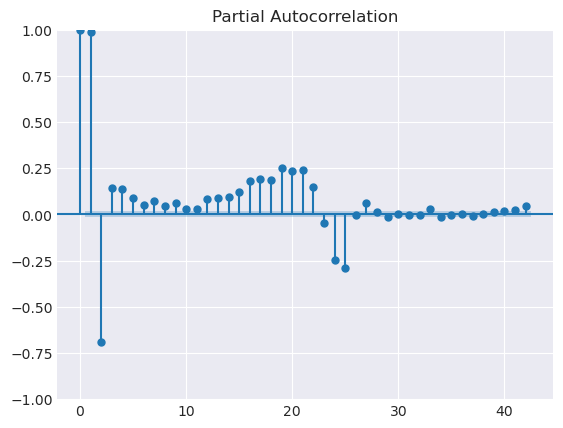

In [72]:
plot_pacf(df_arima_nc)
plt.show()

In [30]:
# Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

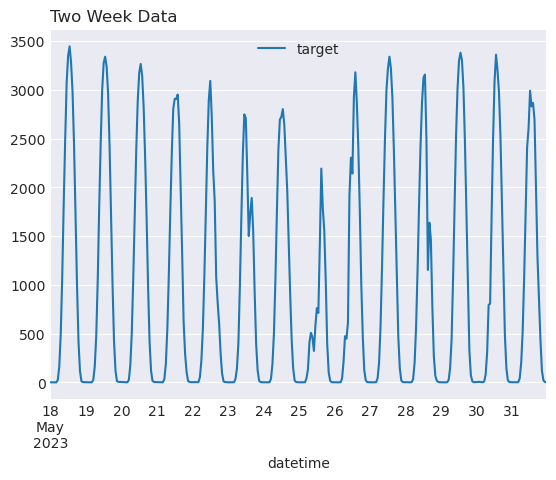

In [31]:
df_arima[-336:].plot()
plt.title('Two Week Data', loc='left')
plt.show()

In [32]:
df_arima_train = df_arima[-336:-24].copy()
df_arima_test = df_arima[-24:].copy()

In [33]:
# TODO: ARIMA 모델 근데 이제 sarimax를 이용함 예제를 보면서 했기 때문..
sarimax = SARIMAX(endog=df_arima_train, trend='c', freq='h', order=(24, 1, 0),
                  seasonal_order=(0, 0, 0, 24)).fit(disp=True)

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54960D+00    |proj g|=  1.08423D-02

At iterate    1    f=  6.54954D+00    |proj g|=  1.62101D-02

At iterate    2    f=  6.54952D+00    |proj g|=  1.31906D-02

At iterate    3    f=  6.54951D+00    |proj g|=  1.14226D-02

At iterate    4    f=  6.54942D+00    |proj g|=  6.69455D-03

At iterate    5    f=  6.54939D+00    |proj g|=  8.68072D-03

At iterate    6    f=  6.54932D+00    |proj g|=  8.27101D-03

At iterate    7    f=  6.54927D+00    |proj g|=  6.96041D-03

At iterate    8    f=  6.54913D+00    |proj g|=  1.26862D-02

At iterate    9    f=  6.54903D+00    |proj g|=  1.31376D-02

At iterate   10    f=  6.54888D+00    |proj g|=  1.29620D-02

At iterate   11    f=  6.54887D+00    |proj g|=  1.24778D-02

At iterate   12    f=  6.54880D+00    |proj g|=  6.73519D-03

At iterate   13    f=  6.5

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# TODO: 5.31일 예측 구경
pred = sarimax.predict(start='2023-05-31 00:00:00', end='2023-05-31 23:00:00',
                dynamic=False)

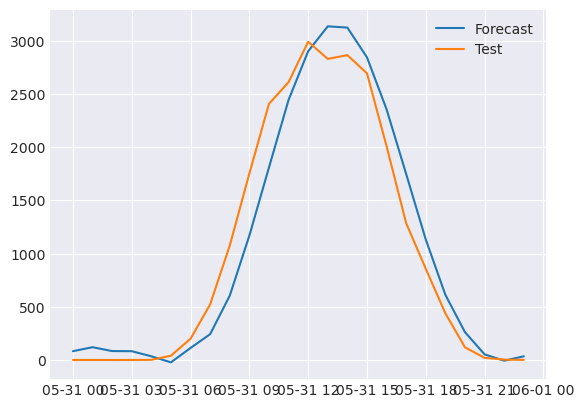

In [35]:
plt.plot(pred, label='Forecast')
plt.plot(df_arima_test, label='Test')
plt.legend()
plt.show()

In [36]:
print(f'SARIMAX Sample Mean Absolute Error: {round(mean_absolute_error(df_arima_test, pred))}')

SARIMAX Sample Mean Absolute Error: 205


In [ ]:
# def mape(y_pred, y_true):
#   return (np.abs(y_pred - y_true)/y_true).mean() * 100

# def mae(y_pred, y_true):
#   return np.abs(y_pred - y_true).mean()

In [37]:
df_arima001 = df_train[(df_train['is_consumption'] == 0) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()

In [45]:
df_arima_train = df_arima001[:-96].copy()
df_arima_test = df_arima001[-96:].copy()

In [39]:
# ARIMA 테스트0
trn_001, tst_001 = df_arima_train[:], df_arima_test[:]

print(trn_001.index)
print(tst_001.index)


DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2023-05-27 14:00:00', '2023-05-27 15:00:00',
               '2023-05-27 16:00:00', '2023-05-27 17:00:00',
               '2023-05-27 18:00:00', '2023-05-27 19:00:00',
               '2023-05-27 20:00:00', '2023-05-27 21:00:00',
               '2023-05-27 22:00:00', '2023-05-27 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=15216, freq=None)
DatetimeIndex(['2023-05-28 00:00:00', '2023-05-28 01:00:00',
               '2023-05-28 02:00:00', '2023-05-28 03:00:00',
               '2023-05-28 04:00:00', '2023-05-28 05:00:00',
               '2023-05-28 06:00:00', '2023-05-28 07:00:00',
               '2023-05-28 08:00:00', '2023-05

In [ ]:
df_train['target'].fillna(df_train['target'].shift(1).fillna(df_train['target'].shift(-1).mean()))

In [40]:
print(trn_001.isnull().sum())
print(tst_001.isnull().sum())


target    4
dtype: int64
target    0
dtype: int64


In [41]:
arma_mod_001 = ARIMA(trn_001, order=(24,1,4), trend='t').fit()

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
prd_001 = arma_mod_001.predict(start=tst_001.index[0], end=tst_001.index[-1], dynamic=False)


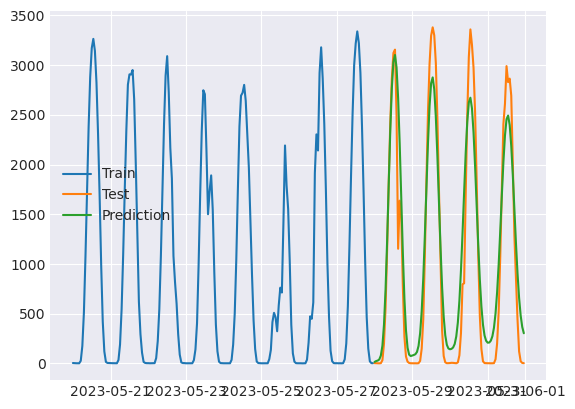

In [47]:
# 예측 결과 생성

plt.plot(trn_001[-192:], label='Train',)
plt.plot(tst_001, label='Test')
plt.plot(prd_001, label='Prediction')
plt.legend()
plt.show()

In [60]:
# MAE 계산
mae_value = mean_absolute_error(tst_001, prd_001)

mape_value = mean_absolute_percentage_error(tst_001, prd_001)

# 결과 출력
print(f"MAE: {mae_value:.4f}")
print(f"MAPE: {mape_value:.4f}")

MAE: 309.4276
MAPE: 18.9013


MissingDataError: exog contains inf or nans

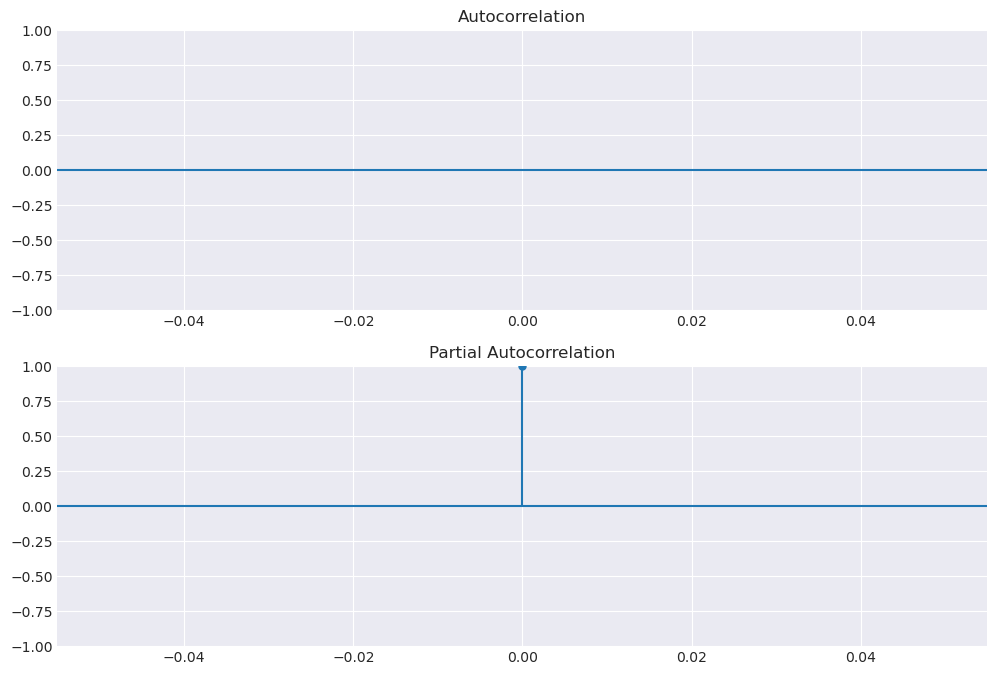

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn_001.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn_001.values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn_001)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

# 여기부터 ARIMA테스트
county, is_produce, product_type, 0 0 1

In [52]:
df_arima_train = df_arima[-336:-24].copy()
df_arima_test = df_arima[-24:].copy()

In [53]:
# ARIMA 테스트..
trn, tst = df_arima_train[:-72], df_arima_train[-72:]
arma_mod = ARIMA(trn, order=(24,1,4), trend='t', freq='h').fit()

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


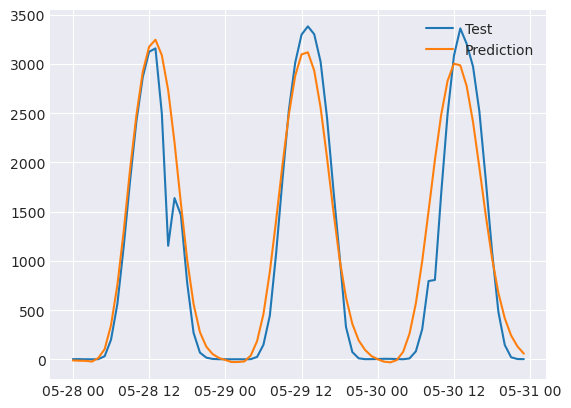

In [54]:
# 예측 결과 생성
prd = arma_mod.predict(start='2023-05-28 00:00:00', end='2023-05-30 23:00:00', dynamic=False)
plt.plot(tst, label='Test')
plt.plot(prd, label='Prediction')
plt.legend()
plt.show()

In [55]:
# MAE 계산
mae_value = mean_absolute_error(tst, prd)

# 결과 출력
print(f"MAE: {mae_value:.4f}")

MAE: 239.9414


아직 안된 부분:
- rolling std, mean 이런거 확인하는 부분
- stationary 확인이 부족하지 않나?
- 일단 dataframe중 2주일 만 가지고 했는데, 전체를 대상으로 해야함
- 다른 segment들에 대해서 해봐야 할듯, 0-0-3 등등..
- ADF 추가하기

# TODO:
Step: 1시간, 그래서 seasonal freq = 24로 설정
Stationary: adf test로 수치 확인하기
전체 기간으로 확인하기 (현재는 마지막 2주를 보고, 4일 예측)


ADF Statistic: -8.67810619443566
p-value: 4.360193518480548e-14
Critical Values:
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


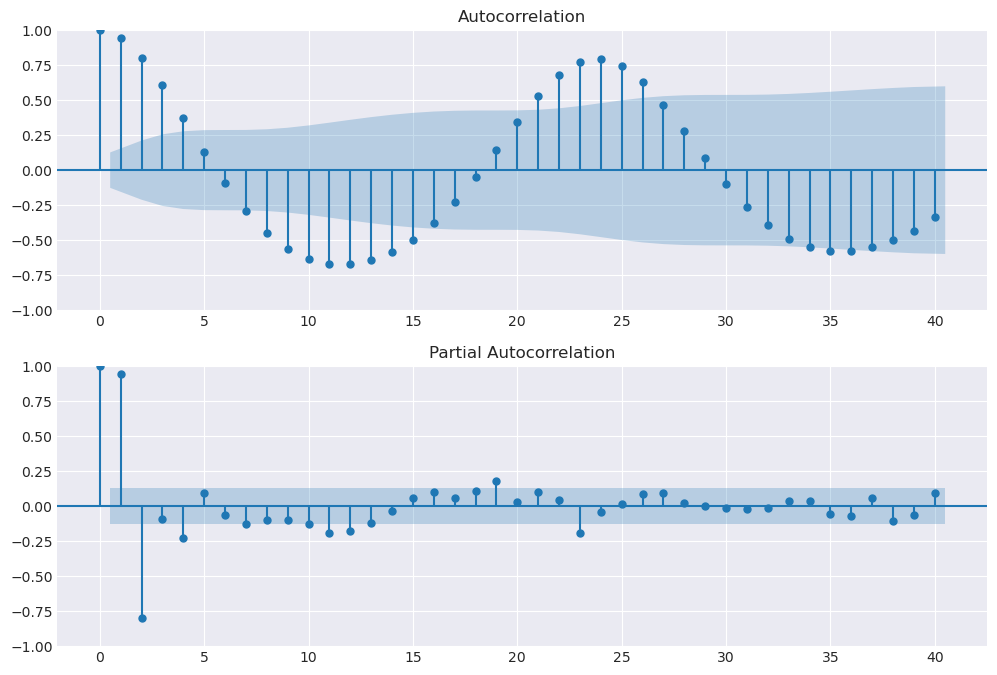

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

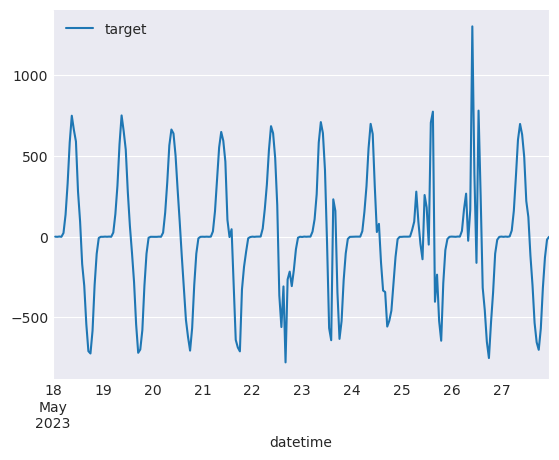

In [57]:
trn.diff(1).plot(label="Diff(1)")
plt.show()

ADF Statistic: -9.68112060596977
p-value: 1.2039006149103449e-16
Critical Values:
	1%: -3.460018927623594
	5%: -2.8745897386146817
	10%: -2.57372514086348


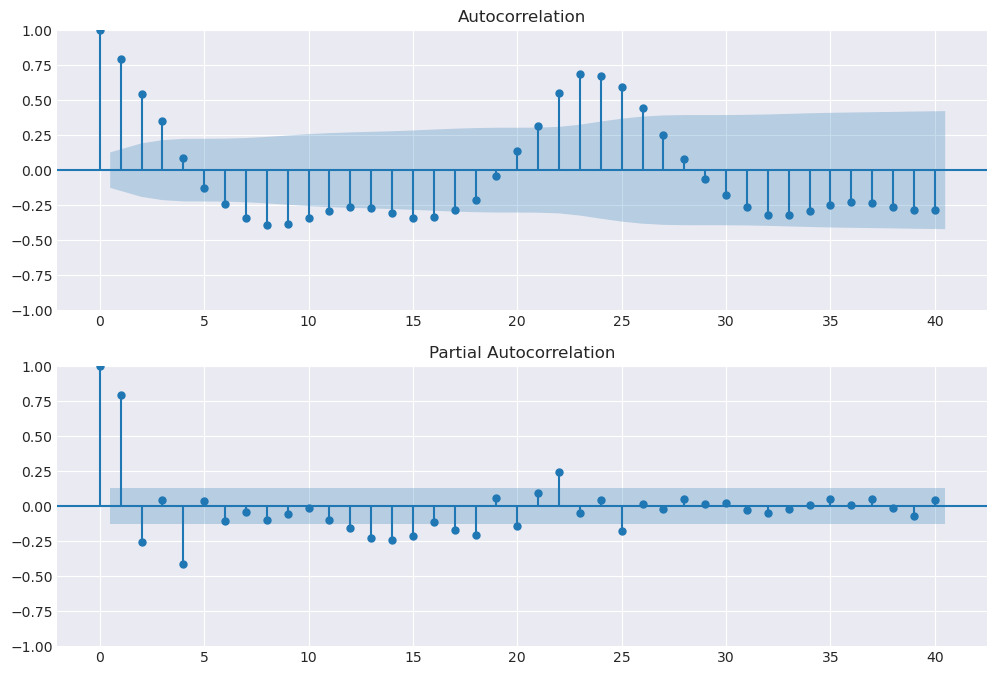

In [58]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.diff(1).dropna().values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.diff(1).dropna().values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn.diff(1).dropna())
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

# 세준님께 궁금한점?

AR
MA 이제 두개 대충 알기만 한 이야기

I는 차분 얘기, => trend?제거?

아직 확실히 모르겠는 부분
window size,
predict size..
다 해결